# Desafio Forecast - Parte 2

## Autor: Raphael Paes Pinto

In [1]:
# Instalação de pacotes
#!pip install keras
#! pip install tensorflow
#!pip install pmdarima

In [2]:
# Pacotes

import pandas as pd
from pandas import Series
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime

import warnings
warnings.simplefilter("ignore")

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pmdarima as pm

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GRU

# configurando pros gráficos ficarem ajustados
plt.style.use('seaborn')

#### Base de dados

In [3]:
# Arquivo com a serie temporal
df = pd.read_csv(r'C:\Users\rapha\Documents\desafio_forecast\dataset\serie\serie_vitimas_desafio.csv', sep = ';', decimal = '.')
#df = pd.read_csv(r'C:\Users\raphael.pinto\Documents\desafio_forecast\dataset\serie\serie_vitimas_desafio.csv', sep = ';', decimal = '.')
df.head()

,data,vitimas_total
0,2015-06-01,6.0
1,2015-06-02,8.0
2,2015-06-03,4.0
3,2015-06-04,4.0
4,2015-06-05,8.0


In [4]:
df.dtypes

data              object
vitimas_total    float64
dtype: object

In [5]:
# No decorrer do código serão sugeridos alguns modelos e métricas para mensurar os resultados

In [6]:
# Para facilitar os próximos passos e seguindo as instruções do desafios:
# separação do material em treino (train) e teste (test)
train = df[(df['data'] >= '2015-06-01') & (df['data'] <= '2018-12-31')]
train['data'] =  pd.to_datetime(train['data'], format='%Y-%m-%d')

test = df[(df['data'] >= '2019-01-01') ]
test['data'] =  pd.to_datetime(test['data'], format='%Y-%m-%d')

In [7]:
# Checando se ficou separado corretamente
print(min(train['data']), max(train['data']), min(test['data']), max(test['data']) )

2015-06-01 00:00:00 2018-12-31 00:00:00 2019-01-01 00:00:00 2019-12-31 00:00:00


### Modelo 1 - Suavização Exponencial Simples

* A suavização exponencial simples, com o próprio nome diz, é o caso particular mais simples de suavização exponencial. Esse tipo de modelo serve para quando não existe nenhum padrão claro de sazonalidade ou tendência na série. (https://blog.curso-r.com/posts/2019-02-10-ses/)

In [8]:
# Definindo o index como cada dia da série, mas sem perder o dado inicial (train)
trainD = train.set_index('data')

# Treinando o modelo de suavização exponencial simples. Com base em testes feitos a constante de suavização que minimiza os erros é a de valor 0.111.
model1 = SimpleExpSmoothing(trainD).fit()

# Previsões
modelo1 = model1.forecast(len(test))
modelo1

C:\Users\rapha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2019-01-01    6.340655
2019-01-02    6.340655
2019-01-03    6.340655
2019-01-04    6.340655
2019-01-05    6.340655
                ...   
2019-12-27    6.340655
2019-12-28    6.340655
2019-12-29    6.340655
2019-12-30    6.340655
2019-12-31    6.340655
Freq: D, Length: 365, dtype: float64

In [9]:
# Métricas para mensurar o modelo
print('Erro médio absoluto (MSE):',
      round(mean_absolute_error(test.set_index('data'), modelo1), 3))
print('Raiz do erro médio quadrado (RMSE):',
      round(mean_squared_error(test.set_index('data'), modelo1)**0.5, 3))
print('Soma quadratica dos erros (SSE):',
      round(np.sum((modelo1.values - test.set_index('data').values)**2), 3))
print('Erro medio percentual absoluto (MAPE):',
      np.mean(np.abs((test.set_index('data').values - modelo1.values)/test.set_index('data').values))*100)

Erro médio absoluto (MSE): 2.631
Raiz do erro médio quadrado (RMSE): 3.345
Soma quadratica dos erros (SSE): 1490702.708
Erro medio percentual absoluto (MAPE): inf


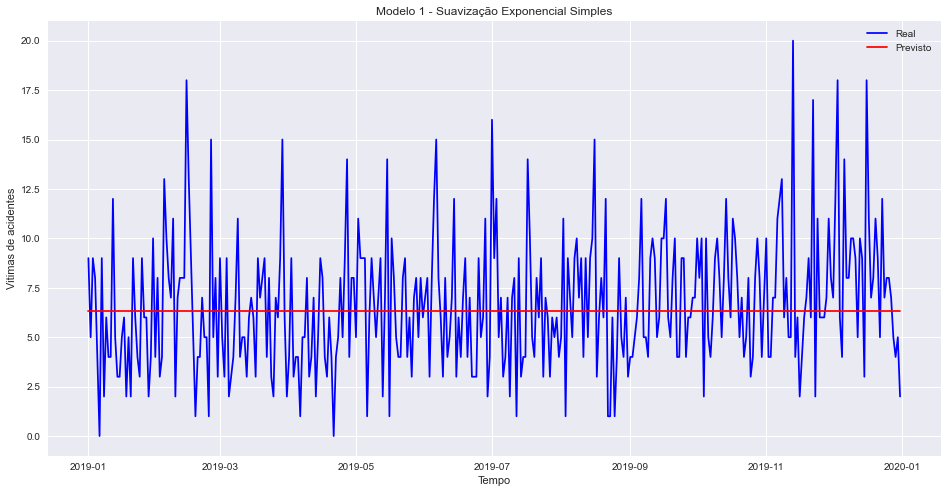

In [10]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test.set_index('data'), color = 'blue', label = 'Real')
ax.plot(modelo1, color = 'red', label = 'Previsto')
ax.set_title('Modelo 1 - Suavização Exponencial Simples')
ax.set_xlabel('Tempo')
ax.set_ylabel('Vitimas de acidentes')
ax.legend()
plt.savefig(r'C:\Users\rapha\Documents\desafio_forecast\imagens\real_previsto_modelo1.png')

### Modelo 2 - Suavização de Media Móvel

* A suavização é uma técnica aplicada a séries temporais para remover a variação refinada entre etapas de tempo. A expectativa da suavização é remover o ruído e expor melhor o sinal dos processos causais subjacentes. As médias móveis são um tipo simples e comum de suavização usado na análise de séries temporais e na previsão de séries temporais.

In [11]:
# Passos a frente: 1, 2 , 3 e 14 
# A seleção do 14 se deve ao fato na análise de autocorrelação, o lag 14, ter um leve destaque (bônus pra análise)

#### Passo 1

In [12]:
# Preparando os valores - PASSO 1
X = train['vitimas_total'].values
window = 1
history = [X[i] for i in range(window)]
testMM = test['vitimas_total'].values
modelo2 = list()

# "Andar" para a frente ao longo do tempo no teste
for t in range(len(testMM)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = testMM[t]
    modelo2.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=6.000000, expected=9.000000
predicted=9.000000, expected=5.000000
predicted=5.000000, expected=9.000000
predicted=9.000000, expected=8.000000
predicted=8.000000, expected=4.000000
predicted=4.000000, expected=0.000000
predicted=0.000000, expected=9.000000
predicted=9.000000, expected=2.000000
predicted=2.000000, expected=6.000000
predicted=6.000000, expected=4.000000
predicted=4.000000, expected=4.000000
predicted=4.000000, expected=12.000000
predicted=12.000000, expected=5.000000
predicted=5.000000, expected=3.000000
predicted=3.000000, expected=3.000000
predicted=3.000000, expected=5.000000
predicted=5.000000, expected=6.000000
predicted=6.000000, expected=2.000000
predicted=2.000000, expected=5.000000
predicted=5.000000, expected=2.000000
predicted=2.000000, expected=9.000000
predicted=9.000000, expected=6.000000
predicted=6.000000, expected=4.000000
predicted=4.000000, expected=3.000000
predicted=3.000000, expected=9.000000
predicted=9.000000, expected=6.000000
predicted=

In [13]:
# Métricas para mensurar o modelo
print('Erro médio absoluto (MSE):',
      round(mean_absolute_error(testMM, modelo2), 3))
print('Raiz do erro médio quadrado (RMSE):',
      round(mean_squared_error(testMM, modelo2)**0.5, 3))
print('Soma quadratica dos erros (SSE):',
      round(np.sum((modelo2 - testMM)**2), 3))
print('Erro medio percentual absoluto (MAPE):',
      np.mean(np.abs((testMM - modelo2)/testMM))*100)

Erro médio absoluto (MSE): 3.551
Raiz do erro médio quadrado (RMSE): 4.579
Soma quadratica dos erros (SSE): 7652.0
Erro medio percentual absoluto (MAPE): inf


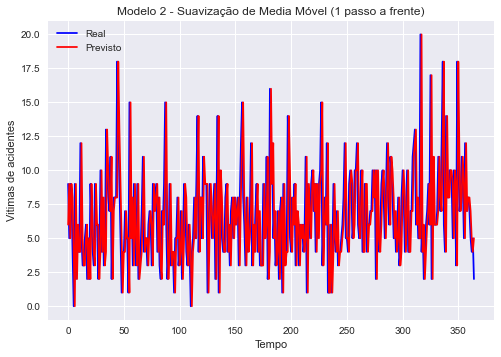

In [14]:
plt.plot(testMM, color = 'blue', label = 'Real')
plt.plot(modelo2, color = 'red', label = 'Previsto')
plt.title('Modelo 2 - Suavização de Media Móvel (1 passo a frente)')
plt.xlabel('Tempo')
plt.ylabel('Vitimas de acidentes')
plt.legend()
plt.show()

#### Passo 2

In [15]:
# Preparando os valores - PASSO 2
X = train['vitimas_total'].values
window = 2
history = [X[i] for i in range(window)]
testMM = test['vitimas_total'].values
modelo2 = list()

# "Andar" para a frente ao longo do tempo no teste
for t in range(len(testMM)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = testMM[t]
    modelo2.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=7.000000, expected=9.000000
predicted=8.500000, expected=5.000000
predicted=7.000000, expected=9.000000
predicted=7.000000, expected=8.000000
predicted=8.500000, expected=4.000000
predicted=6.000000, expected=0.000000
predicted=2.000000, expected=9.000000
predicted=4.500000, expected=2.000000
predicted=5.500000, expected=6.000000
predicted=4.000000, expected=4.000000
predicted=5.000000, expected=4.000000
predicted=4.000000, expected=12.000000
predicted=8.000000, expected=5.000000
predicted=8.500000, expected=3.000000
predicted=4.000000, expected=3.000000
predicted=3.000000, expected=5.000000
predicted=4.000000, expected=6.000000
predicted=5.500000, expected=2.000000
predicted=4.000000, expected=5.000000
predicted=3.500000, expected=2.000000
predicted=3.500000, expected=9.000000
predicted=5.500000, expected=6.000000
predicted=7.500000, expected=4.000000
predicted=5.000000, expected=3.000000
predicted=3.500000, expected=9.000000
predicted=6.000000, expected=6.000000
predicted=7

In [16]:
# Métricas para mensurar o modelo
print('Erro médio absoluto (MSE):',
      round(mean_absolute_error(testMM, modelo2), 3))
print('Raiz do erro médio quadrado (RMSE):',
      round(mean_squared_error(testMM, modelo2)**0.5, 3))
print('Soma quadratica dos erros (SSE):',
      round(np.sum((modelo2 - testMM)**2), 3))
print('Erro medio percentual absoluto (MAPE):',
      np.mean(np.abs((testMM - modelo2)/testMM))*100)

Erro médio absoluto (MSE): 3.16
Raiz do erro médio quadrado (RMSE): 4.003
Soma quadratica dos erros (SSE): 5849.75
Erro medio percentual absoluto (MAPE): inf


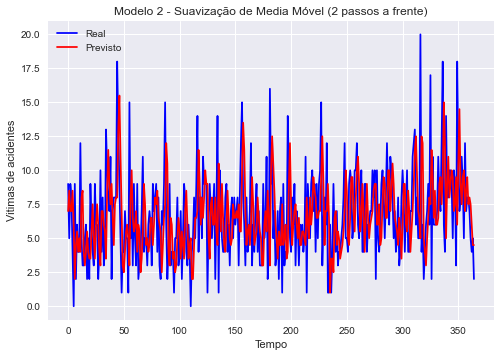

In [17]:
plt.plot(testMM, color = 'blue', label = 'Real')
plt.plot(modelo2, color = 'red', label = 'Previsto')
plt.title('Modelo 2 - Suavização de Media Móvel (2 passos a frente)')
plt.xlabel('Tempo')
plt.ylabel('Vitimas de acidentes')
plt.legend()
plt.show()

#### Passo 3

In [18]:
# Preparando os valores - PASSO 3
X = train['vitimas_total'].values
window = 3
history = [X[i] for i in range(window)]
testMM = test['vitimas_total'].values
modelo2 = list()

# "Andar" para a frente ao longo do tempo no teste
for t in range(len(testMM)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = testMM[t]
    modelo2.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=6.000000, expected=9.000000
predicted=7.000000, expected=5.000000
predicted=6.000000, expected=9.000000
predicted=7.666667, expected=8.000000
predicted=7.333333, expected=4.000000
predicted=7.000000, expected=0.000000
predicted=4.000000, expected=9.000000
predicted=4.333333, expected=2.000000
predicted=3.666667, expected=6.000000
predicted=5.666667, expected=4.000000
predicted=4.000000, expected=4.000000
predicted=4.666667, expected=12.000000
predicted=6.666667, expected=5.000000
predicted=7.000000, expected=3.000000
predicted=6.666667, expected=3.000000
predicted=3.666667, expected=5.000000
predicted=3.666667, expected=6.000000
predicted=4.666667, expected=2.000000
predicted=4.333333, expected=5.000000
predicted=4.333333, expected=2.000000
predicted=3.000000, expected=9.000000
predicted=5.333333, expected=6.000000
predicted=5.666667, expected=4.000000
predicted=6.333333, expected=3.000000
predicted=4.333333, expected=9.000000
predicted=5.333333, expected=6.000000
predicted=6

In [19]:
# Métricas para mensurar o modelo
print('Erro médio absoluto (MSE):',
      round(mean_absolute_error(testMM, modelo2), 3))
print('Raiz do erro médio quadrado (RMSE):',
      round(mean_squared_error(testMM, modelo2)**0.5, 3))
print('Soma quadratica dos erros (SSE):',
      round(np.sum((modelo2 - testMM)**2), 3))
print('Erro medio percentual absoluto (MAPE):',
      np.mean(np.abs((testMM - modelo2)/testMM))*100)

Erro médio absoluto (MSE): 2.933
Raiz do erro médio quadrado (RMSE): 3.73
Soma quadratica dos erros (SSE): 5078.889
Erro medio percentual absoluto (MAPE): inf


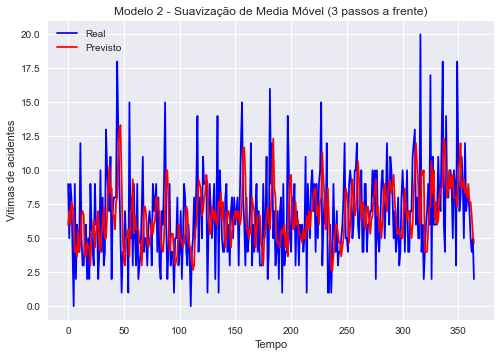

In [20]:
plt.plot(testMM, color = 'blue', label = 'Real')
plt.plot(modelo2, color = 'red', label = 'Previsto')
plt.title('Modelo 2 - Suavização de Media Móvel (3 passos a frente)')
plt.xlabel('Tempo')
plt.ylabel('Vitimas de acidentes')
plt.legend()
plt.show()

#### Passo 14

In [21]:
# Preparando os valores - PASSO 14
X = train['vitimas_total'].values
window = 14
history = [X[i] for i in range(window)]
testMM = test['vitimas_total'].values
modelo2 = list()

# "Andar" para a frente ao longo do tempo no teste
for t in range(len(testMM)):
    length = len(history)
    yhat = mean([history[i] for i in range(length-window,length)])
    obs = testMM[t]
    modelo2.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=7.214286, expected=9.000000
predicted=7.428571, expected=5.000000
predicted=7.214286, expected=9.000000
predicted=7.571429, expected=8.000000
predicted=7.857143, expected=4.000000
predicted=7.571429, expected=0.000000
predicted=6.571429, expected=9.000000
predicted=6.857143, expected=2.000000
predicted=6.285714, expected=6.000000
predicted=5.857143, expected=4.000000
predicted=5.928571, expected=4.000000
predicted=5.428571, expected=12.000000
predicted=5.714286, expected=5.000000
predicted=5.642857, expected=3.000000
predicted=5.714286, expected=3.000000
predicted=5.285714, expected=5.000000
predicted=5.285714, expected=6.000000
predicted=5.071429, expected=2.000000
predicted=4.642857, expected=5.000000
predicted=4.714286, expected=2.000000
predicted=4.857143, expected=9.000000
predicted=4.857143, expected=6.000000
predicted=5.142857, expected=4.000000
predicted=5.000000, expected=3.000000
predicted=4.928571, expected=9.000000
predicted=5.285714, expected=6.000000
predicted=4

In [22]:
# Métricas para mensurar o modelo
print('Erro médio absoluto (MSE):',
      round(mean_absolute_error(testMM, modelo2), 3))
print('Raiz do erro médio quadrado (RMSE):',
      round(mean_squared_error(testMM, modelo2)**0.5, 3))
print('Soma quadratica dos erros (SSE):',
      round(np.sum((modelo2 - testMM)**2), 3))
print('Erro medio percentual absoluto (MAPE):',
      np.mean(np.abs((testMM - modelo2)/testMM))*100)

Erro médio absoluto (MSE): 2.664
Raiz do erro médio quadrado (RMSE): 3.387
Soma quadratica dos erros (SSE): 4186.837
Erro medio percentual absoluto (MAPE): inf


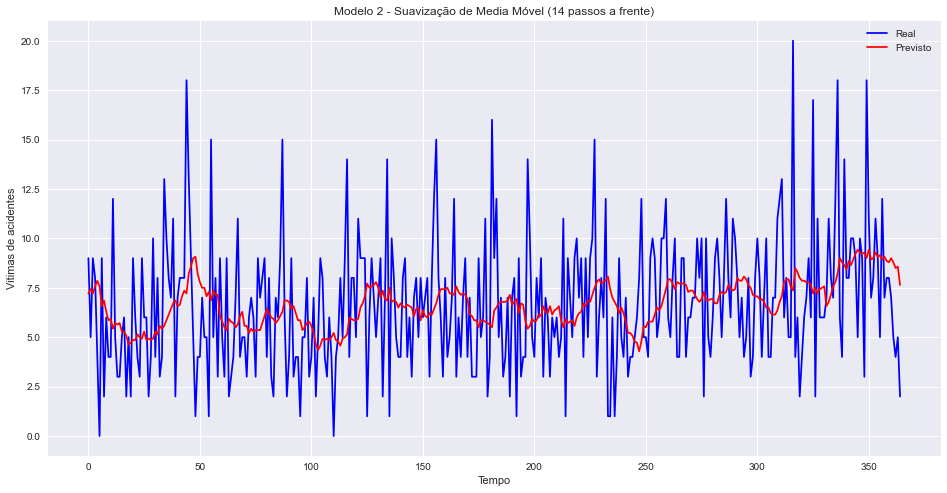

In [23]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(testMM, color = 'blue', label = 'Real')
ax.plot(modelo2, color = 'red', label = 'Previsto')
ax.set_title('Modelo 2 - Suavização de Media Móvel (14 passos a frente)')
ax.set_xlabel('Tempo')
ax.set_ylabel('Vitimas de acidentes')
ax.legend()
plt.savefig(r'C:\Users\rapha\Documents\desafio_forecast\imagens\real_previsto_modelo2.png')

### Modelo 3 - Auto Arima

* Basicamente, o ARIMA utiliza dados passados para prever o futuro, usando dois principais recursos: a autocorrelação e médias móveis. (https://medium.com/techbloghotmart/dicas-para-criar-um-modelo-de-previs%C3%A3o-de-s%C3%A9ries-temporais-d4bb2e32e148)
* o Auto_arima retorna o melhor ajuste ao modelo ARIMA

In [24]:
# Definindo o index como cada dia da série, mas sem perder o dado inicial (train)
trainD = train.set_index('data')
auto_arima = pm.auto_arima(trainD, start_p=0, start_q=0,
                            max_p=4, max_q=4,
                            start_P=0, start_Q=0, seasonal=False,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8843.249, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7656.859, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8279.770, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7354.215, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7203.091, Time=0.09 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=7121.325, Time=0.14 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=6889.316, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=6887.782, Time=0.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=6885.910, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6886.395, Time=0.24 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=6890.350, Time=0.28 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=6885.868, Time=0.33 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8010.715, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=6887.823, Time=0.43 sec
 ARIMA(0,0,3)(0,0,0)[0]          

In [25]:
# Predição do modelo
modelo3 = pd.DataFrame(auto_arima.predict(n_periods = 365), index= test.index)
modelo3.columns = ['previsão_acidentes']
modelo3

,previsão_acidentes
1310,6.070116
1311,5.843750
1312,5.887822
1313,5.925995
1314,5.959060
...,...
1670,6.173055
1671,6.173055
1672,6.173055
1673,6.173055


In [26]:
# Métricas para mensurar o modelo
print('Erro médio absoluto (MSE):',
      round(mean_absolute_error(test.set_index('data'), modelo3), 3))
print('Raiz do erro médio quadrado (RMSE):',
      round(mean_squared_error(test.set_index('data'), modelo3)**0.5, 3))
print('Soma quadratica dos erros (SSE):',
      round(np.sum((modelo3.previsão_acidentes - test.vitimas_total)**2), 3))
print('Erro medio percentual absoluto (MAPE):',
      np.mean(np.abs((test.vitimas_total - modelo3.previsão_acidentes)/test.vitimas_total))*100)

Erro médio absoluto (MSE): 2.623
Raiz do erro médio quadrado (RMSE): 3.365
Soma quadratica dos erros (SSE): 4132.309
Erro medio percentual absoluto (MAPE): inf


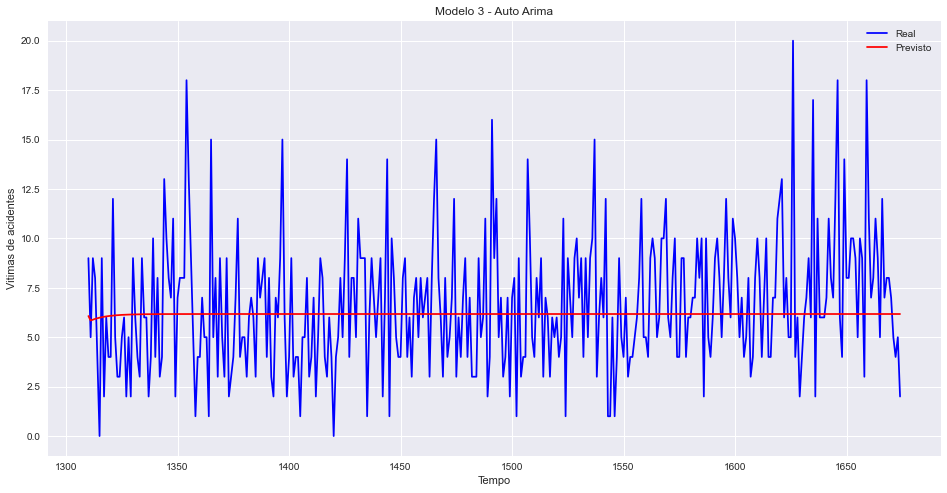

In [27]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test.vitimas_total, color = 'blue', label = 'Real')
ax.plot(modelo3, color = 'red', label = 'Previsto')
ax.set_title('Modelo 3 - Auto Arima')
ax.set_xlabel('Tempo')
ax.set_ylabel('Vitimas de acidentes')
ax.legend()
plt.savefig(r'C:\Users\rapha\Documents\desafio_forecast\imagens\real_previsto_modelo3.png')

### Modelo 4 - Random Forest

* Em português, Random Forest significa floresta aleatória. Este nome explica muito bem o funcionamento do algoritmo, que irá criar muitas árvores de decisão, de maneira aleatória, formando o que podemos enxergar como uma floresta, onde cada árvore será utilizada na escolha do resultado final. (https://didatica.tech/o-que-e-e-como-funciona-o-algoritmo-randomforest/#:~:text=Em%20portugu%C3%AAs%2C%20Random%20Forest%20significa,na%20escolha%20do%20resultado%20final.)

In [28]:
# Para esse modelo é necessário definir bases de treino de teste (separando em variáveis x e y), além da criação de variável dummy
df_md4 = df.copy()
df_md4['data'] = pd.to_datetime(df_md4['data'], format='%Y-%m-%d')
df_md4['month'] = df_md4['data'].dt.month
dummy = pd.get_dummies(df_md4['month'])
df_md4 = pd.concat([df_md4, dummy], axis=1)

In [29]:
# Treino e teste
train = df_md4[(df_md4['data'] >= '2015-06-01') & (df_md4['data'] <= '2018-12-31')]
train = train.drop(['data'], axis=1)
train = train.reset_index(drop=True)

test = df_md4[(df_md4['data'] >= '2019-01-01') ]
test = test.drop(['data'], axis=1)
test = test.reset_index(drop=True)

In [30]:
# Definindo x e y para test
test_md4_x = test.loc[:, test.columns != 'vitimas_total']
test_md4_y = test['vitimas_total']

In [31]:
# Definindo x e y para train
train_md4_x = train.loc[:, train.columns != 'vitimas_total']
train_md4_y = train['vitimas_total']

In [32]:
# Modelagem e previsão
rfe = RFE(estimator = RandomForestRegressor(n_estimators = 100, random_state = 1), n_features_to_select = 4) # https://machinelearningmastery.com/rfe-feature-selection-in-python/
fit = rfe.fit(train_md4_x, train_md4_y)
modelo4 = fit.predict(test_md4_x)

In [33]:
modelo4

array([6.24841328, 6.24841328, 6.24841328, 6.24841328, 6.24841328,
       6.24841328, 6.24841328, 6.24841328, 6.24841328, 6.24841328,
       6.24841328, 6.24841328, 6.24841328, 6.24841328, 6.24841328,
       6.24841328, 6.24841328, 6.24841328, 6.24841328, 6.24841328,
       6.24841328, 6.24841328, 6.24841328, 6.24841328, 6.24841328,
       6.24841328, 6.24841328, 6.24841328, 6.24841328, 6.24841328,
       6.24841328, 5.65500546, 5.65500546, 5.65500546, 5.65500546,
       5.65500546, 5.65500546, 5.65500546, 5.65500546, 5.65500546,
       5.65500546, 5.65500546, 5.65500546, 5.65500546, 5.65500546,
       5.65500546, 5.65500546, 5.65500546, 5.65500546, 5.65500546,
       5.65500546, 5.65500546, 5.65500546, 5.65500546, 5.65500546,
       5.65500546, 5.65500546, 5.65500546, 5.65500546, 5.85186761,
       5.85186761, 5.85186761, 5.85186761, 5.85186761, 5.85186761,
       5.85186761, 5.85186761, 5.85186761, 5.85186761, 5.85186761,
       5.85186761, 5.85186761, 5.85186761, 5.85186761, 5.85186

In [34]:
# Métricas para mensurar o modelo
print('Erro médio absoluto (MSE):',
      round(mean_absolute_error(test_md4_y, modelo4), 3))
print('Raiz do erro médio quadrado (RMSE):',
      round(mean_squared_error(test_md4_y, modelo4)**0.5, 3))
print('Soma quadratica dos erros (SSE):',
      round(np.sum((modelo4 - test_md4_y)**2), 3))
print('Erro medio percentual absoluto (MAPE):',
      np.mean(np.abs((test_md4_y - modelo4)/test_md4_y))*100)

Erro médio absoluto (MSE): 2.614
Raiz do erro médio quadrado (RMSE): 3.343
Soma quadratica dos erros (SSE): 4079.01
Erro medio percentual absoluto (MAPE): inf


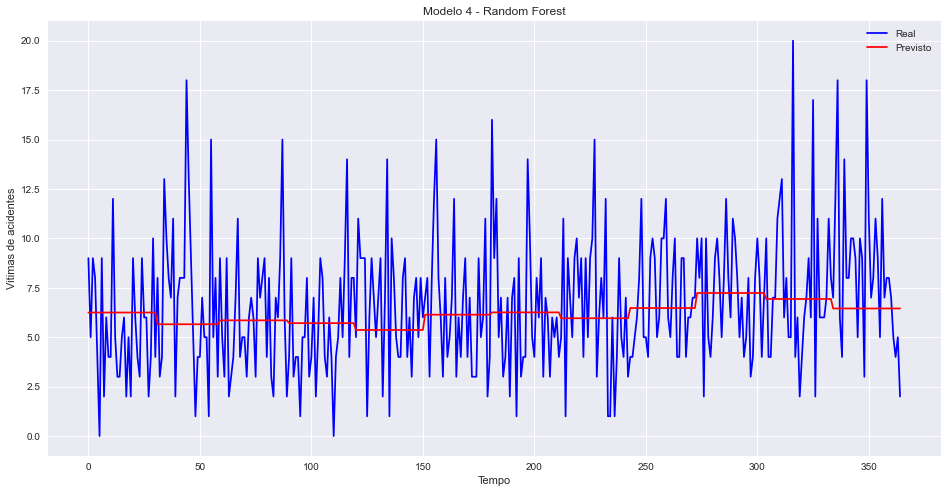

In [35]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test_md4_y, color = 'blue', label = 'Real')
ax.plot(modelo4, color = 'red', label = 'Previsto')
ax.set_title('Modelo 4 - Random Forest')
ax.set_xlabel('Tempo')
ax.set_ylabel('Vitimas de acidentes')
ax.legend()
plt.savefig(r'C:\Users\rapha\Documents\desafio_forecast\imagens\real_previsto_modelo4.png')

### Modelo 5 - RNN (Redes Neurais) [LSTM]

* Uma rede neural recorrente ( RNN ) é uma classe de redes neurais artificiais onde as conexões entre os nós formam um gráfico direcionado ao longo de uma sequência temporal. Isso permite que ele exiba um comportamento dinâmico temporal. (https://stringfixer.com/pt/Recurrent_neural_networks)

In [36]:
# Para facilitar os próximos passos e seguindo as instruções do desafios:
# separação do material em treino (train) e teste (test)
train = df[(df['data'] >= '2015-06-01') & (df['data'] <= '2018-12-31')]
train['data'] =  pd.to_datetime(train['data'], format='%Y-%m-%d')

test = df[(df['data'] >= '2019-01-01') ]
test['data'] =  pd.to_datetime(test['data'], format='%Y-%m-%d')

In [37]:
train

,data,vitimas_total
0,2015-06-01,6.0
1,2015-06-02,8.0
2,2015-06-03,4.0
3,2015-06-04,4.0
4,2015-06-05,8.0
...,...,...
1305,2018-12-27,9.0
1306,2018-12-28,4.0
1307,2018-12-29,4.0
1308,2018-12-30,6.0


In [38]:
# Definindo dados de treino e teste e padronizando
sc = StandardScaler()
train = train.drop(['data'], axis=1)
train = train.reset_index(drop=True)
training_set_scaled = sc.fit_transform(train)

In [39]:
training_set_scaled

array([[-0.06856173],
       [ 0.53021072],
       [-0.66733418],
       ...,
       [-0.66733418],
       [-0.06856173],
       [-1.26610663]])

In [40]:
# Criando as estruturas necessárias (vazias por enquanto...)
X_train = [] 
y_train = []
n_timestep = 14 #tomando como base a análise de auto correlação presente no notebook 1

In [41]:
# Populando as estruturas
for i in range( n_timestep, len(training_set_scaled) ): 
    X_train.append( training_set_scaled[i-n_timestep:i, 0] ) # Linhas 0 a 13 (Coluna 0)
    y_train.append( training_set_scaled[i, 0] ) # 14
print( len(X_train[0]), len(X_train[1]) )

14 14


In [42]:
print( X_train[0], y_train[0] )

[-0.06856173  0.53021072 -0.66733418 -0.66733418  0.53021072  2.32652807
 -0.36794796  1.12898317  1.72775562 -0.96672041  1.4283694   0.53021072
 -0.06856173 -1.26610663] 2.6259142969371023


In [43]:
print( X_train[1], y_train[1] )

[ 0.53021072 -0.66733418 -0.66733418  0.53021072  2.32652807 -0.36794796
  1.12898317  1.72775562 -0.96672041  1.4283694   0.53021072 -0.06856173
 -1.26610663  2.6259143 ] -0.9667204069664005


In [44]:
X_train[2]

array([-0.66733418, -0.66733418,  0.53021072,  2.32652807, -0.36794796,
        1.12898317,  1.72775562, -0.96672041,  1.4283694 ,  0.53021072,
       -0.06856173, -1.26610663,  2.6259143 , -0.96672041])

In [45]:
# Para alimentar na rede, transforma-se em numpy array    
X_train, y_train = np.array(X_train), np.array(y_train)

In [46]:
X_train.shape

(1296, 14)

In [47]:
# Passa-se para a RNN mais de um indicador para prever a saída. Nesse caso tem-se somente 1

# Fazendo no X_train, primeiro parâmetro do método reshape, sendo o segundo parâmetro o novo formato linhas de X, colunas de X e a 3ª dimensão
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1296, 14, 1)

In [48]:
# Modelo
# Inicializando a  RNN
myRNN = Sequential()

In [49]:
# Adicionando a primeira camada de LSTM. 
# Units: número de células LSTM: 
# A camada será formada por várias células (unidades) LSTM paralelas, estruturalmente idênticas, cada uma aprendendo algo específico
# Return sequences: true indica que vamos empilhar outra camada em cima
# Input Shape: (nº de timesteps, número de indicadores)
myRNN.add( GRU(units = 14, return_sequences = True, input_shape = (X_train.shape[1], 1)) )

In [50]:
# Adicionando uma camada regularizadora (para evitar overfitting)
myRNN.add(Dropout(0.2))

In [51]:
# Adicionando uma segunda camada, conforme a primeira (sem o input_shape)
myRNN.add(GRU(units = 22, return_sequences = True))
myRNN.add(Dropout(0.2))

In [52]:
# Adicionando uma terceira camada... Como vou parar de empilhar, não preciso especificar o parâmetro return_sequences
myRNN.add(GRU(units = 22))
myRNN.add(Dropout(0.2))

In [53]:
# Camada de saida - E a função de ativação? Nãoé necessário pois está se prevendo um valor
# Em casos como este, de regressão, não precisamos usar uma função de ativação na última camada.
myRNN.add(Dense(units = 1))

In [54]:
# RMSprop é bem recomendado para RNN
myRNN.compile(optimizer = 'Adam', loss = 'mean_squared_error')

In [55]:
myRNN.fit(X_train, y_train, epochs = 100, batch_size = 30)

Epoch 1/100
44/44 [==============================] - 5s 13ms/step - loss: 0.9989
Epoch 2/100
44/44 [==============================] - 1s 15ms/step - loss: 0.9996
Epoch 3/100
44/44 [==============================] - 1s 13ms/step - loss: 0.9987
Epoch 4/100
44/44 [==============================] - 0s 11ms/step - loss: 0.9985
Epoch 5/100
44/44 [==============================] - 0s 10ms/step - loss: 0.9923
Epoch 6/100
44/44 [==============================] - 1s 11ms/step - loss: 0.9985
Epoch 7/100
44/44 [==============================] - 0s 11ms/step - loss: 0.9938
Epoch 8/100
44/44 [==============================] - 0s 10ms/step - loss: 0.9963
Epoch 9/100
44/44 [==============================] - 0s 10ms/step - loss: 0.9941
Epoch 10/100
44/44 [==============================] - 0s 10ms/step - loss: 0.9974
Epoch 11/100
44/44 [==============================] - 0s 10ms/step - loss: 0.9940
Epoch 12/100
44/44 [==============================] - 0s 10ms/step - loss: 0.9938
Epoch 13/100
44/44 [=====

* Previsão

In [56]:
# Ajustando os dados
df = df.drop(['data'], axis=1)
df = df.reset_index(drop=True)

test = test.drop(['data'], axis=1)
test = test.reset_index(drop=True)

In [57]:
len(df)

1675

In [58]:
# Para cada dia D temos que pegar os n anteriores, definidos por n_timestep
# Vamos passar n_timesteps anteriores a este ponto, então subtraímos n_timestep
# len(dataset_total) - len(dataset_test) - n_timestep define a fronteira inferior. 
# define a fronteira superior: define a superior
inputs = df[ len(df) - len(test) - n_timestep:].values # tornando um array
inputs.shape

(379, 1)

In [59]:
# Feature scaling para os valores... 
inputs = sc.transform(inputs)

In [60]:
# Preparando os inputs para submeter para previsoes. Semelhante ao que foi realizado para o treinamento...
X_test = [] # vai receber os inputs...
for i in range(n_timestep, n_timestep+len(test)):
    X_test.append(inputs[i-n_timestep:i, 0])

In [61]:
# Vamos agora ajustar para enviar para a rede...
# Se quiser relembrar os movitos, ver os comentários que fizemos em cima para o X_train...
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [62]:
modelo5 = myRNN.predict(X_test)

12/12 [==============================] - 1s 3ms/step


In [63]:
modelo5

array([[ 1.25702083e-01],
       [-1.20021505e-02],
       [-7.08523393e-02],
       [-1.20379359e-01],
       [-1.01760015e-01],
       [-3.75226848e-02],
       [-1.26137282e-04],
       [-8.71572122e-02],
       [-8.66505802e-02],
       [-1.45159334e-01],
       [-1.72982886e-01],
       [-1.80244684e-01],
       [-2.29964733e-01],
       [-1.58976346e-01],
       [-6.76047653e-02],
       [-8.45660269e-02],
       [-1.06864676e-01],
       [-1.40043542e-01],
       [-1.12087578e-01],
       [-1.21434428e-01],
       [-1.06189579e-01],
       [-1.80400208e-01],
       [-1.39731869e-01],
       [-7.54837543e-02],
       [-3.17643210e-02],
       [-9.31918472e-02],
       [-1.15160391e-01],
       [-9.20326859e-02],
       [-4.89784144e-02],
       [-7.24316016e-02],
       [-1.44510075e-01],
       [-1.13653332e-01],
       [-1.33931443e-01],
       [-9.30480510e-02],
       [-8.53071436e-02],
       [-1.79452494e-01],
       [-1.64167121e-01],
       [-8.62455219e-02],
       [ 8.2

In [64]:
modelo5 = sc.inverse_transform(modelo5); modelo5

array([[6.648874 ],
       [6.1889186],
       [5.992349 ],
       [5.8269205],
       [5.889112 ],
       [6.103676 ],
       [6.228586 ],
       [5.937888 ],
       [5.9395804],
       [5.744151 ],
       [5.651216 ],
       [5.6269603],
       [5.460887 ],
       [5.698    ],
       [6.0031962],
       [5.946543 ],
       [5.8720617],
       [5.761239 ],
       [5.8546166],
       [5.823396 ],
       [5.8743167],
       [5.626441 ],
       [5.76228  ],
       [5.976879 ],
       [6.1229095],
       [5.9177313],
       [5.8443527],
       [5.921603 ],
       [6.0654116],
       [5.987074 ],
       [5.74632  ],
       [5.8493867],
       [5.7816544],
       [5.9182115],
       [5.9440675],
       [5.6296062],
       [5.680662 ],
       [5.940933 ],
       [6.256661 ],
       [6.126396 ],
       [6.538292 ],
       [6.381389 ],
       [6.2308702],
       [6.211616 ],
       [6.1770077],
       [5.781282 ],
       [5.9102297],
       [7.274028 ],
       [8.909921 ],
       [8.830428 ],


In [65]:
# Métricas para mensurar o modelo
print('Erro médio absoluto (MSE):',
      round(mean_absolute_error(test, modelo5), 3))
print('Raiz do erro médio quadrado (RMSE):',
      round(mean_squared_error(test, modelo5)**0.5, 3))
print('Soma quadratica dos erros (SSE):',
      round(np.sum((modelo5 - test)**2), 3))
print('Erro medio percentual absoluto (MAPE):',
      np.mean(np.abs((test - modelo5)/test))*100)

Erro médio absoluto (MSE): 2.602
Raiz do erro médio quadrado (RMSE): 3.323
Soma quadratica dos erros (SSE): vitimas_total    4031.298
dtype: float64
Erro medio percentual absoluto (MAPE): vitimas_total    inf
dtype: float64


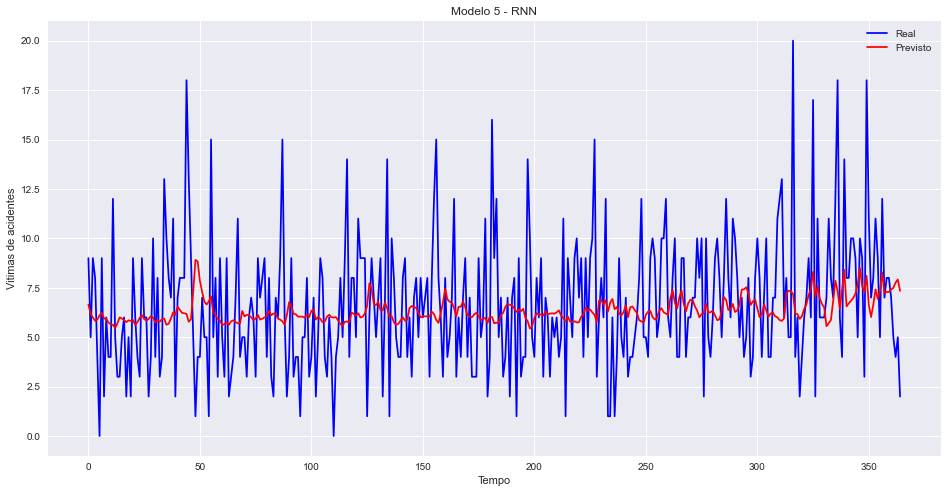

In [66]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(test, color = 'blue', label = 'Real')
ax.plot(modelo5, color = 'red', label = 'Previsto')
ax.set_title('Modelo 5 - RNN')
ax.set_xlabel('Tempo')
ax.set_ylabel('Vitimas de acidentes')
ax.legend()
plt.savefig(r'C:\Users\rapha\Documents\desafio_forecast\imagens\real_previsto_modelo5.png')

## Resultados dos modelos

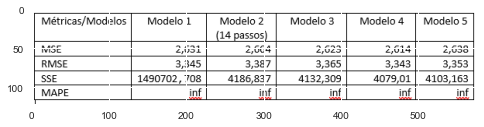

In [67]:
img = mpimg.imread(r'C:\Users\rapha\Documents\desafio_forecast\notebook\imagem\tabela_metricasxmodelos.PNG')
imgplot = plt.imshow(img)
plt.show()

* Tomando como parâmetro os resultados para os testes aplicados em cada modelo, a melhor escolha seria pelo modelo 3 (Auto Arima), que apresentou as menores métricas. Porém observando os valores previstos, a maioria apresenta valores repetidos a partir de um determinado período. Não que haja um erro nisso, mas no meu ponto de vista, escapa um pouco do dinamismo presente nos dados reais das notificações dessas ocorrencias. De toda forma, é uma boa escolha como modelo para previsões dado os dados que foram analizados.
* Com base no cenário dos 5 modelos e todos apresentando métricas bem parecidas, aparentemente qualquer escolha possivelmente, satisfaz e chega na solução do problema. Contudo, caso houvesse uma situação onde fosse necesssário explicar para outra pessoa com pouco conhecimento em previsões e escolha de modelos, o modelo 1 é mais simples de ser explicado e poderia trazer um entendimento mais claro e direto para o tema em questão. Equanto o modelo 5 por ser mais “robusto” e ter mais etapas no processo de previsões, poderia ser uma escolha interessante como uma proposta de metodologia mais técnica e talvez até mais atual.
* Resumindo, os modelos 3 e 5 aparentam ser ótimas escolhas.

#### Pergunta extra: : É possível adicionar outras variáveis para ajudar no processo de previsão? Quais? melhoraram os resultados?

* Quando falamos de processo de previsão, na maioria dos casos, é sempre viável e plausível a incorporação de mais variáveis. Nesse contexto, com um tratamento prévio dos dados, as variáveis que descrevem por qual veículo ocorreu o acidente (moto, carro etc), poderia ser um incremento interessante pro modelo, talvez uma possível variável dummy (sim e não) ou um parâmetro para contabilizar o total de vítimas.
* A variável vítima fatal ou não-fatal, me pareceu interessante e poderia trazer mais profundidade para a interpretação final das análises. 
* Geralmente utilizam-se variáveis demográficas, que em geral são interessantes e como técnica para averiguar compatibilidade com o estudo, a correlação com os dados de notificação, seria interessante para dar um início as análises e quem sabe incorporar no modelo. Além de dados de clima/tempo (precipitação, chuvas etc) que poderia trazer uma abordagem interessante pros resultados.

###### Referências

In [68]:
# https://ivanildo-batista13.medium.com/modelos-de-suaviza%C3%A7%C3%A3o-exponencial-em-python-c495a21d230b
# https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
# https://datapane.com/reports/9Armyrk/arima-for-hierarchical-time-series-forecasting/#:~:text=The%20Python%20framework%20scikit%2Dhts,Top%2DDown%2C%20OLS%20etc.
# https://github.com/SushmithaPulagam/TimeSeries_Auto-ARIMA/blob/master/TimeSeries_AutoARIMA.py
# https://www.analyticsvidhya.com/blog/2021/06/random-forest-for-time-series-forecasting/
# https://www.statology.org/sst-ssr-sse-in-python/
# https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# https://www.askpython.com/python/examples/mape-mean-absolute-percentage-error#:~:text=What%20is%20MAPE%3F,termed%20by%20the%20model%20evaluation.